In [1]:
!date

Thu May  4 09:28:23 EDT 2023


In [2]:
pwd

'/mmfs1/data/aglinska/BC-actionpred-seg'

In [3]:
import PIL
from PIL import Image,ImageFilter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from scipy.ndimage.filters import gaussian_filter
import os
import shutil
import random
#import cv2
from skimage.transform import resize
from datetime import datetime
now = datetime.now

/data/aglinska/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [4]:
def load_video(fn):
    import skvideo
    import skvideo.io
    videodata = skvideo.io.vread(fn)
    return videodata

In [5]:
def safe_mkdir(fn):
    import os
    if not os.path.exists(fn):
        os.mkdir(fn)

In [6]:
def resize_and_pad_video(video_data):

    target_size = np.array((360, 640))
    input_size = (video_data.shape[1],video_data.shape[2])
    
    d1 = input_size[0]/target_size[0]
    d2 = input_size[1]/target_size[1]

    choose_size = input_size/max(d1,d2)
    choose_size = choose_size.round().astype(int) ## Hacks?

    video_data_resized = np.array([np.array(Image.fromarray(video_data[frame,:,:,:]).resize(choose_size.astype(int)[-1::-1])) for frame in range(video_data.shape[0])])

    assert any(video_data_resized.shape[1:3]==target_size),'neither dimension matches'

    if not video_data_resized.shape[1]==target_size[0]:

        if np.mod(video_data_resized.shape[1],2)==0:
            p = (target_size[0]-video_data_resized.shape[1])/2
            pp = (p.astype(int),p.astype(int))
        else:
            p = (target_size[0]-video_data_resized.shape[1])/2
            p = np.floor(p)
            pp = (p.astype(int),p.astype(int)+1)

        video_data_resized_padded = np.pad(video_data_resized,((0,0),(pp[0],pp[1]),(0,0),(0,0)))
        padding = np.pad(np.ones(video_data_resized.shape),((0,0),(pp[0],pp[1]),(0,0),(0,0)))[0,:,:,0]

    elif not video_data_resized.shape[2]==target_size[1]:

        if np.mod(video_data_resized.shape[2],2)==0:
            p = (target_size[1]-video_data_resized.shape[2])/2
            pp = (p.astype(int),p.astype(int))
        else:
            p = (target_size[1]-video_data_resized.shape[2])/2
            p = np.floor(p)
            pp = (p.astype(int),p.astype(int)+1)

        video_data_resized_padded = np.pad(video_data_resized,((0,0),(0,0),(pp[0],pp[1]),(0,0)))
        padding = np.pad(np.ones(video_data_resized.shape),((0,0),(0,0),(pp[0],pp[1]),(0,0)))[0,:,:,0]

    else:
        video_data_resized_padded = video_data_resized
        padding = np.ones(video_data_resized.shape)[0,:,:,0]

    assert all(video_data_resized_padded.shape[1:3]==target_size), 'failed resizing'
    
    return video_data_resized_padded,padding

In [7]:
categories = os.listdir('./Data/haa500_v1_1_frames/video/')
categories.sort()
print(categories[0:3])
print(categories[-3::])

['ALS_IceBucket_Challenge', 'CPR', 'abseiling']
['yoga_tree', 'yoga_triangle', 'yoga_updog']


In [8]:
calc_or_load = 'load'

if calc_or_load=='load':
    idx_1p = np.load('good_videos_1p_new_4783.npy')
    
elif calc_or_load=='calc':
    
    idx_1p = np.zeros((20,500))
    box_fn = './Data/haa500_v1_1_frames/video/{c}/{c}_{v:03d}/{c}_{v:03d}_{f:03d}_box.npy'
    for c in tqdm(range(500)):
        for v in range(20):
            boxes = [f for f in os.listdir(f'./Data/haa500_v1_1_frames/video/{categories[c]}/{categories[c]}_{v:03d}/') if f.endswith('_box.npy')]
            n = len(boxes)
            idx_1p[v,c] = all([sum(np.load(box_fn.format(c=categories[c],v=v,f=f))[:,-1]==0)==1 for f in range(n)])
    #np.save('good_videos_1p_new_4783.npy',idx_1p)
else:
    print('undefined')

[0. 1.]
4783.0
(20, 500)


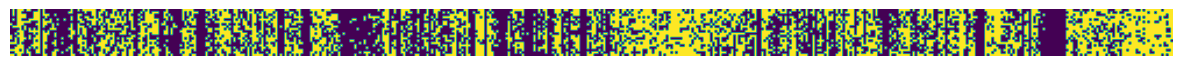

In [9]:
print(np.unique(idx_1p))
print(idx_1p.sum())
print(idx_1p.shape)
plt.figure(figsize=(15,5))
plt.imshow(idx_1p);
plt.axis('off');

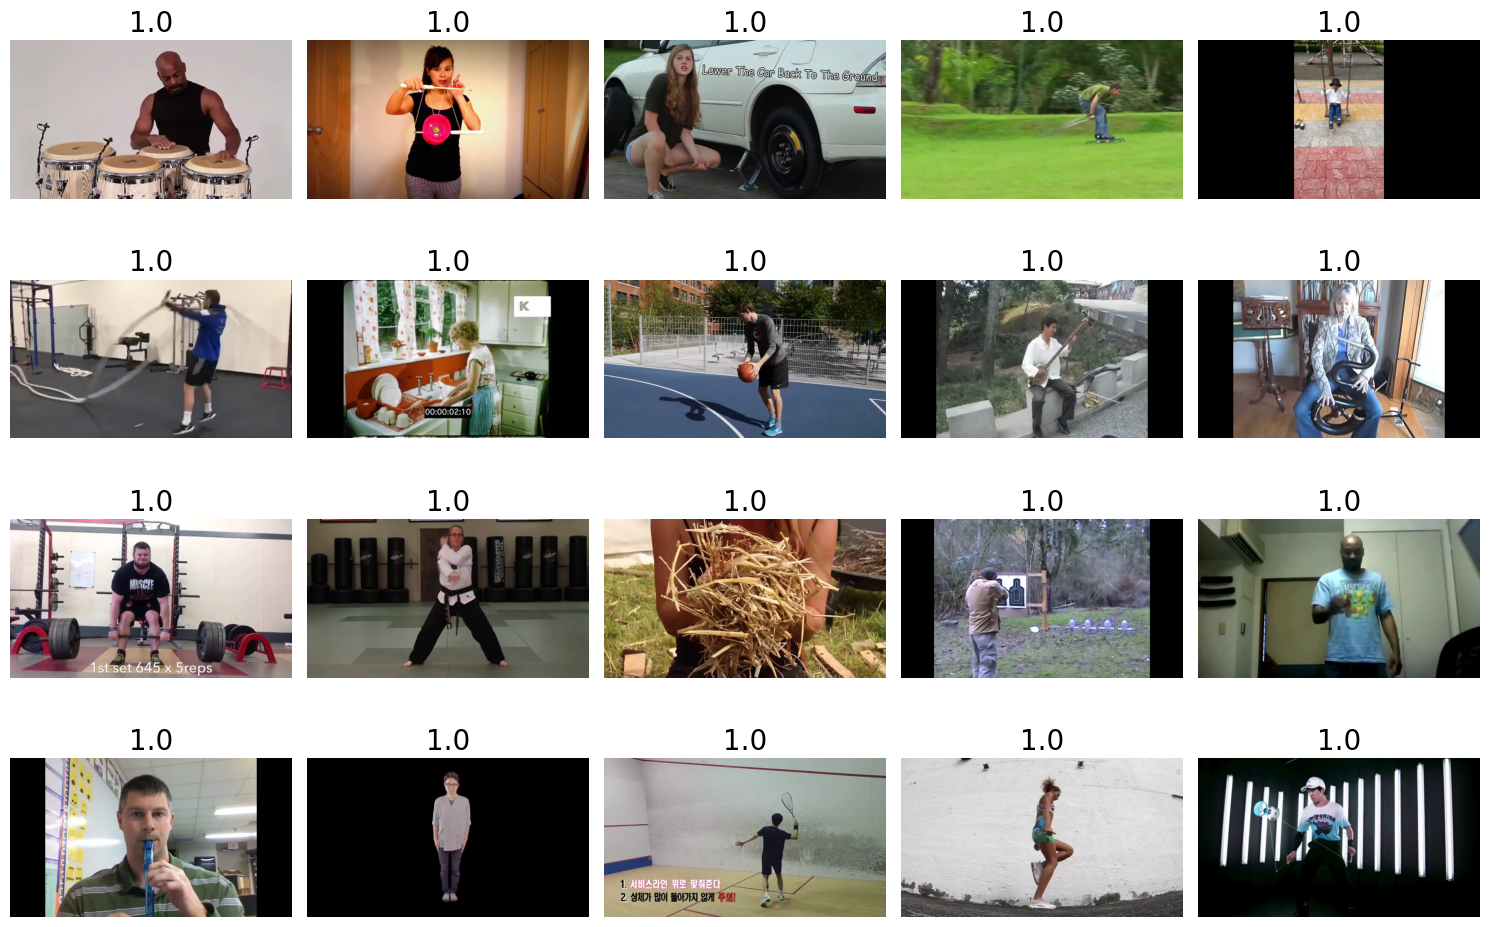

In [10]:
nz = np.nonzero(idx_1p)
plt.figure(figsize=(15,10))
for i in range(20):
    plt.subplot(4,5,i+1)
    r = np.random.randint(low=0,high=len(nz[0]))
    #c = np.random.randint(low=0,high=500)
    #v = np.random.randint(low=0,high=20)
    c = nz[1][r]
    v = nz[0][r]
    f = 0

    im = Image.open('./Data/haa500_v1_1_frames/video/{c}/{c}_{v:03d}/{c}_{v:03d}_{f:03d}.png'.format(c=categories[c],v=v,f=f))
    plt.imshow(np.array(im))
    plt.axis('off')
    plt.title(idx_1p[v,c],fontsize=20)
    
plt.tight_layout()

In [11]:
has_vids = np.zeros((20,500))
for c in tqdm(range(500)):
    for v in range(20):
        fn1 = './Data/haa500_v1_1_yolo_seg4/{c}/{c}_{v:03d}.mp4'.format(c=categories[c],v=v)
        fn2 = './Data/haa500_v1_1_yolo_seg4/{c}/{c}_{v:03d}_item_0_fwd_seg.mp4'.format(c=categories[c],v=v)
        fn3 = './Data/haa500_v1_1_yolo_seg4/{c}/{c}_{v:03d}_item_0_inp_seg.mp4'.format(c=categories[c],v=v)
        has_vids[v,c] = all([os.path.exists(fn) for fn in [fn1,fn2,fn3]])

  0%|          | 0/500 [00:00<?, ?it/s]

  1%|          | 3/500 [00:00<00:16, 29.67it/s]

  1%|▏         | 7/500 [00:00<00:16, 30.63it/s]

  2%|▏         | 11/500 [00:00<00:15, 31.63it/s]

  3%|▎         | 15/500 [00:00<00:14, 32.81it/s]

  4%|▍         | 20/500 [00:00<00:13, 35.55it/s]

  5%|▍         | 24/500 [00:00<00:13, 35.86it/s]

  6%|▌         | 28/500 [00:00<00:13, 35.31it/s]

  6%|▋         | 32/500 [00:00<00:12, 36.39it/s]

  7%|▋         | 36/500 [00:01<00:13, 35.44it/s]

  8%|▊         | 40/500 [00:01<00:13, 35.29it/s]

  9%|▉         | 44/500 [00:01<00:12, 36.02it/s]

 10%|▉         | 48/500 [00:01<00:12, 36.12it/s]

 10%|█         | 52/500 [00:01<00:12, 34.97it/s]

 11%|█         | 56/500 [00:01<00:12, 35.70it/s]

 12%|█▏        | 60/500 [00:01<00:12, 35.03it/s]

 13%|█▎        | 64/500 [00:01<00:12, 34.68it/s]

 14%|█▍        | 69/500 [00:01<00:11, 36.31it/s]

 15%|█▍        | 74/500 [00:02<00:11, 37.48it/s]

 16%|█▌        | 78/500 [00:02<00:11, 37.33it/s]

 16%|█▋        | 82/500 [00:02<00:11, 36.75it/s]

 17%|█▋        | 86/500 [00:02<00:11, 36.35it/s]

 18%|█▊        | 90/500 [00:02<00:11, 36.48it/s]

 19%|█▉        | 94/500 [00:02<00:11, 35.69it/s]

 20%|█▉        | 98/500 [00:02<00:11, 35.81it/s]

 20%|██        | 102/500 [00:02<00:10, 36.95it/s]

 21%|██        | 106/500 [00:02<00:10, 37.15it/s]

 22%|██▏       | 111/500 [00:03<00:09, 39.56it/s]

 23%|██▎       | 115/500 [00:03<00:10, 38.33it/s]

 24%|██▍       | 119/500 [00:03<00:09, 38.39it/s]

 25%|██▍       | 123/500 [00:03<00:10, 37.10it/s]

 25%|██▌       | 127/500 [00:03<00:09, 37.52it/s]

 26%|██▋       | 132/500 [00:03<00:08, 41.04it/s]

 27%|██▋       | 137/500 [00:03<00:09, 38.30it/s]

 28%|██▊       | 141/500 [00:03<00:09, 36.65it/s]

 29%|██▉       | 146/500 [00:04<00:09, 37.83it/s]

 30%|███       | 151/500 [00:04<00:08, 39.20it/s]

 31%|███       | 155/500 [00:04<00:08, 38.89it/s]

 32%|███▏      | 159/500 [00:04<00:08, 39.09it/s]

 33%|███▎      | 164/500 [00:04<00:08, 39.47it/s]

 34%|███▍      | 169/500 [00:04<00:08, 39.98it/s]

 35%|███▍      | 174/500 [00:04<00:08, 38.64it/s]

 36%|███▌      | 178/500 [00:04<00:08, 38.63it/s]

 36%|███▋      | 182/500 [00:04<00:08, 37.53it/s]

 37%|███▋      | 186/500 [00:05<00:08, 36.51it/s]

 38%|███▊      | 190/500 [00:05<00:08, 35.65it/s]

 39%|███▉      | 194/500 [00:05<00:08, 36.55it/s]

 40%|███▉      | 198/500 [00:05<00:08, 37.31it/s]

 41%|████      | 203/500 [00:05<00:07, 39.29it/s]

 41%|████▏     | 207/500 [00:05<00:07, 38.51it/s]

 42%|████▏     | 212/500 [00:05<00:07, 40.58it/s]

 43%|████▎     | 217/500 [00:05<00:06, 41.28it/s]

 44%|████▍     | 222/500 [00:05<00:06, 41.28it/s]

 45%|████▌     | 227/500 [00:06<00:06, 42.71it/s]

 46%|████▋     | 232/500 [00:06<00:06, 41.73it/s]

 47%|████▋     | 237/500 [00:06<00:06, 40.61it/s]

 48%|████▊     | 242/500 [00:06<00:06, 38.53it/s]

 49%|████▉     | 246/500 [00:06<00:06, 38.85it/s]

 50%|█████     | 251/500 [00:06<00:06, 41.36it/s]

 51%|█████     | 256/500 [00:06<00:05, 42.51it/s]

 52%|█████▏    | 261/500 [00:06<00:05, 42.19it/s]

 53%|█████▎    | 266/500 [00:07<00:05, 40.76it/s]

 54%|█████▍    | 271/500 [00:07<00:05, 40.85it/s]

 55%|█████▌    | 276/500 [00:07<00:05, 41.00it/s]

 56%|█████▌    | 281/500 [00:07<00:05, 40.61it/s]

 57%|█████▋    | 286/500 [00:07<00:05, 40.62it/s]

 58%|█████▊    | 291/500 [00:07<00:05, 39.78it/s]

 59%|█████▉    | 295/500 [00:07<00:05, 39.36it/s]

 60%|██████    | 300/500 [00:07<00:05, 39.83it/s]

 61%|██████    | 304/500 [00:07<00:04, 39.85it/s]

 62%|██████▏   | 308/500 [00:08<00:04, 39.01it/s]

 62%|██████▏   | 312/500 [00:08<00:04, 39.12it/s]

 63%|██████▎   | 316/500 [00:08<00:04, 38.94it/s]

 64%|██████▍   | 321/500 [00:08<00:04, 39.70it/s]

 65%|██████▌   | 326/500 [00:08<00:04, 40.91it/s]

 66%|██████▌   | 331/500 [00:08<00:04, 40.51it/s]

 67%|██████▋   | 336/500 [00:08<00:04, 39.49it/s]

 68%|██████▊   | 340/500 [00:08<00:04, 37.05it/s]

 69%|██████▉   | 344/500 [00:09<00:04, 35.80it/s]

 70%|██████▉   | 348/500 [00:09<00:04, 36.32it/s]

 70%|███████   | 352/500 [00:09<00:04, 36.25it/s]

 71%|███████▏  | 357/500 [00:09<00:03, 38.01it/s]

 72%|███████▏  | 362/500 [00:09<00:03, 38.60it/s]

 73%|███████▎  | 366/500 [00:09<00:03, 38.89it/s]

 74%|███████▍  | 370/500 [00:09<00:03, 38.23it/s]

 75%|███████▍  | 374/500 [00:09<00:03, 37.87it/s]

 76%|███████▌  | 380/500 [00:09<00:02, 42.04it/s]

 77%|███████▋  | 385/500 [00:10<00:02, 41.32it/s]

 78%|███████▊  | 390/500 [00:10<00:02, 42.82it/s]

 79%|███████▉  | 395/500 [00:10<00:02, 41.17it/s]

 80%|████████  | 400/500 [00:10<00:02, 39.61it/s]

 81%|████████  | 404/500 [00:10<00:02, 38.28it/s]

 82%|████████▏ | 408/500 [00:10<00:02, 37.85it/s]

 82%|████████▏ | 412/500 [00:10<00:02, 37.17it/s]

 83%|████████▎ | 416/500 [00:10<00:02, 37.83it/s]

 85%|████████▍ | 423/500 [00:10<00:01, 44.52it/s]

 86%|████████▌ | 428/500 [00:11<00:01, 41.98it/s]

 87%|████████▋ | 433/500 [00:11<00:01, 40.61it/s]

 88%|████████▊ | 438/500 [00:11<00:01, 36.54it/s]

 88%|████████▊ | 442/500 [00:11<00:01, 33.99it/s]

 89%|████████▉ | 447/500 [00:11<00:01, 37.28it/s]

 90%|█████████ | 451/500 [00:11<00:01, 36.13it/s]

 91%|█████████ | 456/500 [00:11<00:01, 37.26it/s]

 92%|█████████▏| 460/500 [00:12<00:01, 35.04it/s]

 93%|█████████▎| 464/500 [00:12<00:01, 31.57it/s]

 94%|█████████▎| 468/500 [00:12<00:01, 30.51it/s]

 94%|█████████▍| 472/500 [00:12<00:00, 28.34it/s]

 95%|█████████▌| 475/500 [00:12<00:00, 27.38it/s]

 96%|█████████▌| 478/500 [00:12<00:00, 25.67it/s]

 96%|█████████▌| 481/500 [00:12<00:00, 24.66it/s]

 97%|█████████▋| 484/500 [00:13<00:00, 23.67it/s]

 97%|█████████▋| 487/500 [00:13<00:00, 19.37it/s]

 98%|█████████▊| 490/500 [00:13<00:00, 17.85it/s]

 99%|█████████▊| 493/500 [00:13<00:00, 18.28it/s]

 99%|█████████▉| 495/500 [00:13<00:00, 17.33it/s]

 99%|█████████▉| 497/500 [00:13<00:00, 16.58it/s]

100%|█████████▉| 499/500 [00:14<00:00, 15.97it/s]

100%|██████████| 500/500 [00:14<00:00, 35.42it/s]

In [12]:
print(has_vids.sum())
print((has_vids==0).sum())

9371.0
629


In [13]:
good_videos_xl = has_vids.astype(bool)*idx_1p.astype(bool)
good_videos_xl.shape

(20, 500)

In [14]:
print(sum(good_videos_xl.sum(axis=0)>=17))
print(sum(good_videos_xl.sum(axis=0)>=15))
print(sum(good_videos_xl.sum(axis=0)>=10))

60
121
280


In [15]:
minVids = 10

In [16]:
good_videos_xl[:,good_videos_xl.sum(axis=0)<minVids]=0

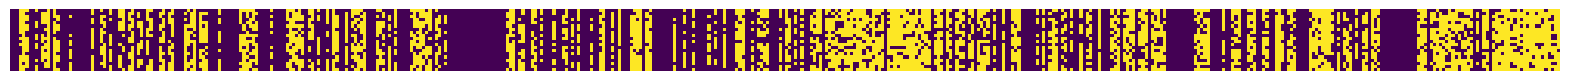

In [17]:
plt.figure(figsize=(20,5))
plt.imshow(good_videos_xl)
plt.axis('off');

In [18]:
good_cats = np.nonzero(good_videos_xl.sum(axis=0)>=minVids)[0]
good_cats_list = list(np.array(categories)[good_cats])
good_vids = [np.nonzero(good_videos_xl[:,good_cat])[0][0:minVids] for good_cat in good_cats]

In [19]:
ng = len(good_cats)
print(ng)

280


In [20]:
# parameters
outdir = './Data/pytorch-data/xl_121_15_action_data_orig'
fn_temp = './Data/haa500_v1_1_yolo_seg4/{c}/{c}_{v:03d}.mp4'
# './Data/haa500_v1_1_yolo_seg4/{c}/{c}_{v:03d}.mp4'
# './Data/haa500_v1_1_yolo_seg4/{c}/{c}_{v:03d}_item_0_fwd_seg.mp4'
# './Data/haa500_v1_1_yolo_seg4/{c}/{c}_{v:03d}_item_0_inp_seg.mp4'
#fn_temp = './Data/haa500_v1_1_resized/video/{c}/{c}_{v:03d}.mp4'

In [21]:
# Parameters
outdir = "./Data/pytorch-data/xl_280_10_action_data_orig"
fn_temp = "./Data/haa500_v1_1_yolo_seg4/{c}/{c}_{v:03d}.mp4"


In [22]:
## Make/Define Directories
safe_mkdir(outdir)

safe_mkdir(os.path.join(outdir,'train'))
safe_mkdir(os.path.join(outdir,'val'))
safe_mkdir(os.path.join(outdir,'test'))

[safe_mkdir(os.path.join(outdir,'train',category)) for category in good_cats_list];
[safe_mkdir(os.path.join(outdir,'val',category)) for category in good_cats_list];
[safe_mkdir(os.path.join(outdir,'test',category)) for category in good_cats_list];

In [23]:
# Run Main Loop
for c in tqdm(range(ng)):
    for v in range(minVids):              
        fn = fn_temp.format(c=categories[good_cats[c]],v=good_vids[c][v])
        video_data = load_video(fn)
        assert all((video_data.shape[1]==360,video_data.shape[2]==640)),f'bad size dumbass: {video_data.shape}'
        
        nframes = video_data.shape[0]
        video_data = resize(np.pad(video_data,((0,0),(140,140),(0,0),(0,0))),(nframes,224,224,3)) # resize to 244*244 (0-1 range)
        video_data = (video_data*255).astype(np.uint8) # make into 0-255 uint
              
        if v==0:
            outdir_subfolder = os.path.join(outdir,'val',categories[good_cats[c]])
        elif v==1:
            outdir_subfolder = os.path.join(outdir,'test',categories[good_cats[c]])
        else:
            outdir_subfolder = os.path.join(outdir,'train',categories[good_cats[c]])

        [Image.fromarray(video_data[f,:,:,:]).save(os.path.join(outdir_subfolder,f'{good_vids[c][v]:03d}_{f:03d}.jpg')) for f in range(nframes)];

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 1/280 [01:29<6:56:37, 89.60s/it]

  1%|          | 2/280 [01:54<3:58:28, 51.47s/it]

  1%|          | 3/280 [02:37<3:40:58, 47.86s/it]

  1%|▏         | 4/280 [03:35<3:58:18, 51.81s/it]

  2%|▏         | 5/280 [04:22<3:49:22, 50.05s/it]

  2%|▏         | 6/280 [04:50<3:13:20, 42.34s/it]

  2%|▎         | 7/280 [05:26<3:03:24, 40.31s/it]

  3%|▎         | 8/280 [05:52<2:42:05, 35.75s/it]

  3%|▎         | 9/280 [06:05<2:09:39, 28.71s/it]

  4%|▎         | 10/280 [06:23<1:54:49, 25.52s/it]

  4%|▍         | 11/280 [08:15<3:52:56, 51.96s/it]

  4%|▍         | 12/280 [08:38<3:12:03, 43.00s/it]

  5%|▍         | 13/280 [08:55<2:36:50, 35.24s/it]

  5%|▌         | 14/280 [09:15<2:15:28, 30.56s/it]

  5%|▌         | 15/280 [09:43<2:12:01, 29.89s/it]

  6%|▌         | 16/280 [10:41<2:48:23, 38.27s/it]

  6%|▌         | 17/280 [11:10<2:35:04, 35.38s/it]

  6%|▋         | 18/280 [15:45<7:49:29, 107.52s/it]

  7%|▋         | 19/280 [28:41<22:21:08, 308.31s/it]

  7%|▋         | 20/280 [29:12<16:15:09, 225.04s/it]

  8%|▊         | 21/280 [29:29<11:42:13, 162.68s/it]

  8%|▊         | 22/280 [30:12<9:04:06, 126.54s/it] 

  8%|▊         | 23/280 [30:49<7:07:10, 99.73s/it] 

  9%|▊         | 24/280 [31:17<5:33:54, 78.26s/it]

  9%|▉         | 25/280 [31:49<4:33:45, 64.41s/it]

  9%|▉         | 26/280 [32:39<4:13:45, 59.94s/it]

 10%|▉         | 27/280 [33:01<3:24:39, 48.54s/it]

 10%|█         | 28/280 [33:37<3:08:08, 44.80s/it]

 10%|█         | 29/280 [33:59<2:39:26, 38.11s/it]

 11%|█         | 30/280 [35:06<3:15:04, 46.82s/it]

 11%|█         | 31/280 [35:47<3:07:11, 45.11s/it]

 11%|█▏        | 32/280 [36:12<2:41:19, 39.03s/it]

 12%|█▏        | 33/280 [37:04<2:56:13, 42.81s/it]

 12%|█▏        | 34/280 [37:39<2:46:08, 40.52s/it]

 12%|█▎        | 35/280 [48:02<14:39:06, 215.29s/it]

 13%|█▎        | 36/280 [1:00:20<25:12:38, 371.96s/it]

 13%|█▎        | 37/280 [1:00:47<18:07:56, 268.63s/it]

 14%|█▎        | 38/280 [1:01:20<13:18:44, 198.04s/it]

 14%|█▍        | 39/280 [1:02:12<10:19:11, 154.16s/it]

 14%|█▍        | 40/280 [1:02:44<7:49:17, 117.32s/it] 

 15%|█▍        | 41/280 [1:03:16<6:05:47, 91.83s/it] 

 15%|█▌        | 42/280 [1:04:09<5:18:05, 80.19s/it]

 15%|█▌        | 43/280 [1:10:04<10:42:27, 162.65s/it]

 16%|█▌        | 44/280 [1:10:45<8:16:05, 126.13s/it] 

 16%|█▌        | 45/280 [1:11:20<6:26:44, 98.74s/it] 

 16%|█▋        | 46/280 [1:11:47<5:01:24, 77.28s/it]

 17%|█▋        | 47/280 [1:12:04<3:50:18, 59.31s/it]

 17%|█▋        | 48/280 [1:12:41<3:22:49, 52.45s/it]

 18%|█▊        | 49/280 [1:13:27<3:15:04, 50.67s/it]

 18%|█▊        | 50/280 [1:14:04<2:58:35, 46.59s/it]

 18%|█▊        | 51/280 [1:14:38<2:43:14, 42.77s/it]

 19%|█▊        | 52/280 [1:15:17<2:38:13, 41.64s/it]

 19%|█▉        | 53/280 [1:15:56<2:33:42, 40.63s/it]

 19%|█▉        | 54/280 [1:16:21<2:15:43, 36.03s/it]

 20%|█▉        | 55/280 [1:17:08<2:27:37, 39.37s/it]

 20%|██        | 56/280 [1:18:10<2:52:49, 46.29s/it]

 20%|██        | 57/280 [1:18:40<2:33:25, 41.28s/it]

 21%|██        | 58/280 [1:28:27<12:38:15, 204.94s/it]

 21%|██        | 59/280 [1:55:24<38:34:59, 628.51s/it]

 21%|██▏       | 60/280 [2:05:54<38:27:01, 629.19s/it]

 22%|██▏       | 61/280 [2:18:22<40:25:40, 664.57s/it]

 22%|██▏       | 62/280 [2:37:13<48:43:30, 804.64s/it]

 22%|██▎       | 63/280 [2:56:13<54:33:27, 905.10s/it]

 23%|██▎       | 64/280 [3:24:36<68:40:17, 1144.53s/it]

 23%|██▎       | 65/280 [4:11:44<98:31:36, 1649.75s/it]

 24%|██▎       | 66/280 [4:28:26<86:31:07, 1455.46s/it]

 24%|██▍       | 67/280 [5:02:35<96:38:41, 1633.43s/it]

 24%|██▍       | 68/280 [5:32:27<98:59:20, 1680.95s/it]

 25%|██▍       | 69/280 [5:36:02<72:44:28, 1241.08s/it]

 25%|██▌       | 70/280 [5:39:18<54:06:45, 927.65s/it] 

 25%|██▌       | 71/280 [5:54:16<53:20:32, 918.82s/it]

 26%|██▌       | 72/280 [6:33:09<77:35:34, 1342.95s/it]

 26%|██▌       | 73/280 [6:34:52<55:49:44, 970.94s/it] 

 26%|██▋       | 74/280 [7:14:37<79:50:35, 1395.32s/it]

 27%|██▋       | 75/280 [7:36:31<78:03:49, 1370.88s/it]

 27%|██▋       | 76/280 [8:06:07<84:33:37, 1492.24s/it]

 28%|██▊       | 77/280 [8:09:29<62:19:32, 1105.28s/it]

 28%|██▊       | 78/280 [8:27:18<61:24:39, 1094.45s/it]

 28%|██▊       | 79/280 [8:43:35<59:08:40, 1059.31s/it]

 29%|██▊       | 80/280 [8:46:30<44:06:40, 794.00s/it] 

 29%|██▉       | 81/280 [9:12:15<56:20:47, 1019.33s/it]

 29%|██▉       | 82/280 [9:39:45<66:27:22, 1208.30s/it]

 30%|██▉       | 83/280 [9:40:25<46:56:26, 857.80s/it] 

 30%|███       | 84/280 [9:48:10<40:18:00, 740.21s/it]

 30%|███       | 85/280 [10:11:47<51:05:31, 943.24s/it]

 31%|███       | 86/280 [10:13:07<36:51:41, 684.03s/it]

 31%|███       | 87/280 [10:17:01<29:26:13, 549.08s/it]

 31%|███▏      | 88/280 [10:17:17<20:45:23, 389.19s/it]

 32%|███▏      | 89/280 [10:34:14<30:38:31, 577.55s/it]

 32%|███▏      | 90/280 [10:35:45<22:46:54, 431.66s/it]

 32%|███▎      | 91/280 [10:36:10<16:15:05, 309.55s/it]

 33%|███▎      | 92/280 [10:36:36<11:43:03, 224.38s/it]

 33%|███▎      | 93/280 [10:36:56<8:28:34, 163.18s/it] 

 34%|███▎      | 94/280 [10:37:19<6:15:57, 121.28s/it]

 34%|███▍      | 95/280 [10:37:40<4:41:02, 91.15s/it] 

 34%|███▍      | 96/280 [10:53:37<17:55:59, 350.87s/it]

 35%|███▍      | 97/280 [11:19:52<36:30:17, 718.13s/it]

 35%|███▌      | 98/280 [11:47:41<50:43:12, 1003.25s/it]

 35%|███▌      | 99/280 [12:09:59<55:29:39, 1103.76s/it]

 36%|███▌      | 100/280 [13:11:15<93:46:31, 1875.51s/it]

 36%|███▌      | 101/280 [13:33:18<85:00:10, 1709.55s/it]

 36%|███▋      | 102/280 [14:16:17<97:25:36, 1970.43s/it]

 37%|███▋      | 103/280 [14:37:06<86:14:41, 1754.13s/it]

 37%|███▋      | 104/280 [15:20:45<98:26:07, 2013.45s/it]

 38%|███▊      | 105/280 [15:42:35<87:37:00, 1802.41s/it]

 38%|███▊      | 106/280 [15:50:03<67:28:52, 1396.16s/it]

 38%|███▊      | 107/280 [16:04:36<59:33:10, 1239.25s/it]

 39%|███▊      | 108/280 [16:18:10<53:06:52, 1111.70s/it]

 39%|███▉      | 109/280 [16:59:33<72:20:57, 1523.14s/it]

 39%|███▉      | 110/280 [17:37:53<82:55:29, 1756.05s/it]

 40%|███▉      | 111/280 [18:23:18<96:05:11, 2046.81s/it]

 40%|████      | 112/280 [19:30:46<123:31:41, 2647.03s/it]

 40%|████      | 113/280 [19:52:56<104:27:53, 2251.94s/it]

 41%|████      | 114/280 [20:37:32<109:42:09, 2379.09s/it]

 41%|████      | 115/280 [20:38:43<77:18:41, 1686.80s/it] 

 41%|████▏     | 116/280 [21:04:41<75:05:01, 1648.18s/it]

 42%|████▏     | 117/280 [21:45:23<85:24:34, 1886.35s/it]

 42%|████▏     | 118/280 [22:39:27<103:12:45, 2293.61s/it]

 42%|████▎     | 119/280 [22:39:52<72:08:03, 1612.94s/it] 

 43%|████▎     | 120/280 [22:40:32<50:42:43, 1141.02s/it]

 43%|████▎     | 121/280 [22:41:09<35:46:32, 810.02s/it] 

 44%|████▎     | 122/280 [22:41:50<25:25:26, 579.28s/it]

 44%|████▍     | 123/280 [22:42:20<18:04:15, 414.37s/it]

 44%|████▍     | 124/280 [22:42:51<12:58:36, 299.46s/it]

 45%|████▍     | 125/280 [22:43:16<9:21:08, 217.22s/it] 

 45%|████▌     | 126/280 [22:44:06<7:08:05, 166.79s/it]

 45%|████▌     | 127/280 [22:44:55<5:35:55, 131.74s/it]

 46%|████▌     | 128/280 [22:45:27<4:17:17, 101.56s/it]

 46%|████▌     | 129/280 [22:45:45<3:12:50, 76.63s/it] 

 46%|████▋     | 130/280 [22:46:05<2:28:53, 59.56s/it]

 47%|████▋     | 131/280 [22:46:37<2:07:37, 51.39s/it]

 47%|████▋     | 132/280 [22:47:25<2:04:03, 50.29s/it]

 48%|████▊     | 133/280 [22:48:06<1:56:15, 47.45s/it]

 48%|████▊     | 134/280 [22:48:53<1:55:14, 47.36s/it]

 48%|████▊     | 135/280 [22:50:14<2:18:46, 57.42s/it]

 49%|████▊     | 136/280 [22:50:46<2:00:01, 50.01s/it]

 49%|████▉     | 137/280 [22:51:33<1:56:50, 49.03s/it]

 49%|████▉     | 138/280 [22:52:44<2:11:51, 55.71s/it]

 50%|████▉     | 139/280 [22:54:30<2:46:21, 70.79s/it]

 50%|█████     | 140/280 [22:55:03<2:18:30, 59.36s/it]

 50%|█████     | 141/280 [22:55:37<2:00:00, 51.80s/it]

 51%|█████     | 142/280 [22:56:10<1:46:05, 46.13s/it]

 51%|█████     | 143/280 [22:56:56<1:44:55, 45.96s/it]

 51%|█████▏    | 144/280 [22:57:27<1:33:51, 41.41s/it]

 52%|█████▏    | 145/280 [22:58:02<1:29:20, 39.71s/it]

 52%|█████▏    | 146/280 [22:58:28<1:19:32, 35.62s/it]

 52%|█████▎    | 147/280 [22:59:01<1:16:40, 34.59s/it]

 53%|█████▎    | 148/280 [22:59:43<1:20:57, 36.80s/it]

 53%|█████▎    | 149/280 [23:00:40<1:34:12, 43.15s/it]

 54%|█████▎    | 150/280 [23:01:11<1:24:58, 39.22s/it]

 54%|█████▍    | 151/280 [23:01:52<1:25:42, 39.86s/it]

 54%|█████▍    | 152/280 [23:03:01<1:43:38, 48.58s/it]

 55%|█████▍    | 153/280 [23:03:32<1:31:38, 43.30s/it]

 55%|█████▌    | 154/280 [23:04:17<1:31:49, 43.73s/it]

 55%|█████▌    | 155/280 [23:17:45<9:29:00, 273.13s/it]

 56%|█████▌    | 156/280 [23:48:42<25:46:48, 748.46s/it]

 56%|█████▌    | 157/280 [24:15:02<34:05:40, 997.89s/it]

 56%|█████▋    | 158/280 [24:15:42<24:04:18, 710.31s/it]

 57%|█████▋    | 159/280 [24:16:35<17:15:06, 513.27s/it]

 57%|█████▋    | 160/280 [25:03:00<39:49:30, 1194.75s/it]

 57%|█████▊    | 161/280 [25:50:13<55:44:08, 1686.12s/it]

 58%|█████▊    | 162/280 [26:41:15<68:48:15, 2099.11s/it]

 58%|█████▊    | 163/280 [27:05:02<61:39:33, 1897.21s/it]

 59%|█████▊    | 164/280 [27:05:27<43:02:16, 1335.66s/it]

 59%|█████▉    | 165/280 [27:06:44<30:36:07, 957.98s/it] 

 59%|█████▉    | 166/280 [27:07:34<21:42:32, 685.55s/it]

 60%|█████▉    | 167/280 [27:08:12<15:25:31, 491.43s/it]

 60%|██████    | 168/280 [27:08:48<11:02:18, 354.81s/it]

 60%|██████    | 169/280 [27:09:28<8:01:47, 260.43s/it] 

 61%|██████    | 170/280 [27:15:28<8:51:58, 290.17s/it]

 61%|██████    | 171/280 [28:01:30<31:14:36, 1031.90s/it]

 61%|██████▏   | 172/280 [28:43:30<44:20:48, 1478.23s/it]

 62%|██████▏   | 173/280 [29:32:27<56:56:29, 1915.79s/it]

 62%|██████▏   | 174/280 [30:09:37<59:10:57, 2009.98s/it]

 62%|██████▎   | 175/280 [31:00:38<67:49:33, 2325.46s/it]

 63%|██████▎   | 176/280 [31:23:59<59:10:03, 2048.11s/it]

 63%|██████▎   | 177/280 [31:29:48<44:00:34, 1538.20s/it]

 64%|██████▎   | 178/280 [31:34:00<32:39:02, 1152.38s/it]

 64%|██████▍   | 179/280 [31:34:41<22:58:36, 818.97s/it] 

 64%|██████▍   | 180/280 [31:35:18<16:14:20, 584.60s/it]

 65%|██████▍   | 181/280 [31:43:01<15:04:05, 547.93s/it]

 65%|██████▌   | 182/280 [32:17:45<27:27:38, 1008.76s/it]

 65%|██████▌   | 183/280 [32:35:21<27:33:59, 1023.09s/it]

 66%|██████▌   | 184/280 [32:48:06<25:13:05, 945.68s/it] 

 66%|██████▌   | 185/280 [33:11:35<28:37:22, 1084.66s/it]

 66%|██████▋   | 186/280 [33:11:54<19:58:19, 764.89s/it] 

 67%|██████▋   | 187/280 [33:12:17<14:00:27, 542.24s/it]

 67%|██████▋   | 188/280 [33:13:01<10:02:26, 392.90s/it]

 68%|██████▊   | 189/280 [33:13:35<7:12:38, 285.26s/it] 

 68%|██████▊   | 190/280 [33:14:03<5:11:53, 207.93s/it]

 68%|██████▊   | 191/280 [33:14:42<3:53:25, 157.37s/it]

 69%|██████▊   | 192/280 [33:15:31<3:03:03, 124.81s/it]

 69%|██████▉   | 193/280 [33:16:09<2:23:19, 98.84s/it] 

 69%|██████▉   | 194/280 [33:16:36<1:50:43, 77.25s/it]

 70%|██████▉   | 195/280 [33:16:58<1:25:40, 60.47s/it]

 70%|███████   | 196/280 [33:17:31<1:13:27, 52.47s/it]

 70%|███████   | 197/280 [33:18:18<1:09:58, 50.59s/it]

 71%|███████   | 198/280 [33:21:18<2:02:22, 89.54s/it]

 71%|███████   | 199/280 [33:24:07<2:32:53, 113.25s/it]

 71%|███████▏  | 200/280 [33:25:44<2:24:45, 108.57s/it]

 72%|███████▏  | 201/280 [33:26:09<1:49:52, 83.45s/it] 

 72%|███████▏  | 202/280 [33:26:43<1:29:15, 68.66s/it]

 72%|███████▎  | 203/280 [33:28:38<1:46:01, 82.62s/it]

 73%|███████▎  | 204/280 [33:30:52<2:04:04, 97.95s/it]

 73%|███████▎  | 205/280 [33:34:52<2:55:29, 140.39s/it]

 74%|███████▎  | 206/280 [33:36:25<2:35:49, 126.35s/it]

 74%|███████▍  | 207/280 [33:38:03<2:23:15, 117.75s/it]

 74%|███████▍  | 208/280 [33:41:07<2:45:15, 137.72s/it]

 75%|███████▍  | 209/280 [33:43:37<2:47:22, 141.45s/it]

 75%|███████▌  | 210/280 [33:45:41<2:38:52, 136.17s/it]

 75%|███████▌  | 211/280 [34:04:17<8:14:27, 429.96s/it]

 76%|███████▌  | 212/280 [34:06:58<6:36:04, 349.48s/it]

 76%|███████▌  | 213/280 [34:16:34<7:45:54, 417.24s/it]

 76%|███████▋  | 214/280 [34:17:00<5:29:59, 299.99s/it]

 77%|███████▋  | 215/280 [34:17:15<3:52:14, 214.38s/it]

 77%|███████▋  | 216/280 [34:17:35<2:46:34, 156.16s/it]

 78%|███████▊  | 217/280 [34:17:49<1:59:07, 113.45s/it]

 78%|███████▊  | 218/280 [34:18:03<1:26:36, 83.81s/it] 

 78%|███████▊  | 219/280 [34:18:38<1:10:04, 68.93s/it]

 79%|███████▊  | 220/280 [34:19:03<55:59, 55.98s/it]  

 79%|███████▉  | 221/280 [34:21:10<1:15:53, 77.18s/it]

 79%|███████▉  | 222/280 [34:41:49<6:51:38, 425.84s/it]

 80%|███████▉  | 223/280 [34:55:14<8:32:33, 539.54s/it]

 80%|████████  | 224/280 [35:11:43<10:29:22, 674.34s/it]

 80%|████████  | 225/280 [35:25:29<10:59:41, 719.66s/it]

 81%|████████  | 226/280 [35:37:54<10:54:43, 727.47s/it]

 81%|████████  | 227/280 [35:47:53<10:08:24, 688.76s/it]

 81%|████████▏ | 228/280 [35:50:18<7:35:40, 525.78s/it] 

 82%|████████▏ | 229/280 [35:50:44<5:19:22, 375.74s/it]

 82%|████████▏ | 230/280 [35:58:57<5:42:23, 410.87s/it]

 82%|████████▎ | 231/280 [36:40:46<14:09:40, 1040.41s/it]

 83%|████████▎ | 232/280 [36:51:18<12:14:24, 918.01s/it] 

 83%|████████▎ | 233/280 [37:12:39<13:24:15, 1026.70s/it]

 84%|████████▎ | 234/280 [37:23:44<11:43:57, 918.22s/it] 

 84%|████████▍ | 235/280 [37:31:07<9:41:44, 775.66s/it] 

 84%|████████▍ | 236/280 [37:49:47<10:44:35, 878.98s/it]

 85%|████████▍ | 237/280 [38:02:49<10:09:07, 849.94s/it]

 85%|████████▌ | 238/280 [38:26:43<11:57:38, 1025.19s/it]

 85%|████████▌ | 239/280 [38:33:16<9:30:58, 835.57s/it]  

 86%|████████▌ | 240/280 [39:03:00<12:26:40, 1120.02s/it]

 86%|████████▌ | 241/280 [39:24:57<12:46:24, 1179.09s/it]

 86%|████████▋ | 242/280 [39:25:36<8:50:04, 836.95s/it]  

 87%|████████▋ | 243/280 [39:26:09<6:07:23, 595.78s/it]

 87%|████████▋ | 244/280 [39:49:22<8:21:01, 835.03s/it]

 88%|████████▊ | 245/280 [40:26:40<12:12:33, 1255.82s/it]

 88%|████████▊ | 246/280 [40:35:43<9:50:28, 1042.02s/it] 

 88%|████████▊ | 247/280 [40:36:40<6:50:39, 746.66s/it] 

 89%|████████▊ | 248/280 [40:37:01<4:42:03, 528.86s/it]

 89%|████████▉ | 249/280 [40:37:19<3:14:00, 375.51s/it]

 89%|████████▉ | 250/280 [40:37:38<2:14:20, 268.69s/it]

 90%|████████▉ | 251/280 [40:38:08<1:35:12, 196.97s/it]

 90%|█████████ | 252/280 [40:38:53<1:10:45, 151.63s/it]

 90%|█████████ | 253/280 [40:39:47<55:02, 122.33s/it]  

 91%|█████████ | 254/280 [40:40:48<44:59, 103.83s/it]

 91%|█████████ | 255/280 [40:42:15<41:08, 98.74s/it] 

 91%|█████████▏| 256/280 [40:43:33<37:00, 92.54s/it]

 92%|█████████▏| 257/280 [40:44:27<31:03, 81.01s/it]

 92%|█████████▏| 258/280 [40:46:56<37:11, 101.43s/it]

 92%|█████████▎| 259/280 [40:49:42<42:16, 120.78s/it]

 93%|█████████▎| 260/280 [40:53:06<48:36, 145.84s/it]

 93%|█████████▎| 261/280 [40:55:27<45:43, 144.39s/it]

 94%|█████████▎| 262/280 [40:57:15<40:00, 133.34s/it]

 94%|█████████▍| 263/280 [40:59:31<38:00, 134.17s/it]

 94%|█████████▍| 264/280 [41:00:58<31:58, 119.91s/it]

 95%|█████████▍| 265/280 [41:03:03<30:23, 121.59s/it]

 95%|█████████▌| 266/280 [41:04:48<27:12, 116.62s/it]

 95%|█████████▌| 267/280 [41:10:50<41:12, 190.23s/it]

 96%|█████████▌| 268/280 [41:13:56<37:46, 188.90s/it]

 96%|█████████▌| 269/280 [41:17:16<35:14, 192.24s/it]

 96%|█████████▋| 270/280 [41:20:48<33:02, 198.28s/it]

 97%|█████████▋| 271/280 [41:22:30<25:23, 169.26s/it]

 97%|█████████▋| 272/280 [41:24:56<21:39, 162.42s/it]

 98%|█████████▊| 273/280 [41:28:34<20:53, 179.09s/it]

 98%|█████████▊| 274/280 [41:29:11<13:37, 136.32s/it]

 98%|█████████▊| 275/280 [41:31:40<11:40, 140.07s/it]

 99%|█████████▊| 276/280 [41:34:04<09:25, 141.42s/it]

 99%|█████████▉| 277/280 [41:36:22<07:00, 140.16s/it]

 99%|█████████▉| 278/280 [41:40:18<05:38, 169.18s/it]

100%|█████████▉| 279/280 [41:42:26<02:36, 156.68s/it]

100%|██████████| 280/280 [41:46:04<00:00, 175.07s/it]

100%|██████████| 280/280 [41:46:04<00:00, 537.02s/it]